# NBA Awards Predictor - Part 2

The following notebook is part 2 of the NBA awards predictor project. This notebook includes **exploratory data analysis**. The purpose of this notebook is to take the variables and target column of the datasets and inspect any relationships through visualizations. This will provide me with better knowledge of the dataset and the necessary information for data preprocessing. Part 3 will involve *data preprocessing, feature selection, model training, and model boosting*

Below is a more detailed table of contents for this notebooks

*NOTE:* The last 3 sections are significantly shorter because the majority of the features are already explored in MVP and MIP

**Table of Contents**

1. MVP
    - Analysis of Target Variable
        - Univariate Analysis
        - Bivariate: Numerical Features
        - Bivariate: Categorical Features
    - Analysis of Features
        - Discrete Numerical
        - Continous Numerical
        - Observing Skewness
        - Categorical
    - Missing Values
    - Outlier Analysis
    - Checking Multicollinearity
        - Bivariate Correlations
        - Variance Inflation Factor Method
2. MIP
    - Analysis of Target Variable
        - Univariate Analysis
        - Bivariate Analysis
    - Analysis of Features
        - Continuous Numerical
        - Evaluating Skewness
    - Missing Values and Outliers
    - Checking Multicollinearity
3. DPOY
    - Analysis of Target Variable
    - Analyzing Missing Values
4. ROY
    - Analysis of Target Variable
5. SMOY
    - Analysis of Target Variable

## Importing Necessary Libraries and Datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from itertools import product
from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

In [26]:
mvp = pd.read_csv("../data/awards_dfs/MVP.csv")
mip = pd.read_csv("../data/awards_dfs/MIP.csv")
smoy = pd.read_csv("../data/awards_dfs/SMOY.csv")
roy = pd.read_csv("../data/awards_dfs/ROY.csv")
dpoy = pd.read_csv("../data/awards_dfs/DPOY.csv")

# 1. Most Valuable Player

### Univariate Analysis of Target Variable

In [11]:
mvp["Share"].describe()

count    226.000000
mean       0.173588
std        0.281519
min        0.001000
25%        0.002000
50%        0.021000
75%        0.236250
max        1.000000
Name: Share, dtype: float64

Before plotting the data, we can see through the summary of the data that the distribution will be *skewed right* (Even excluding NaN values). This is seen through the significant difference between the mean and median values, as well as the 75% and max values.

In [34]:
sns.set_style("darkgrid")

/Users/justingong/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


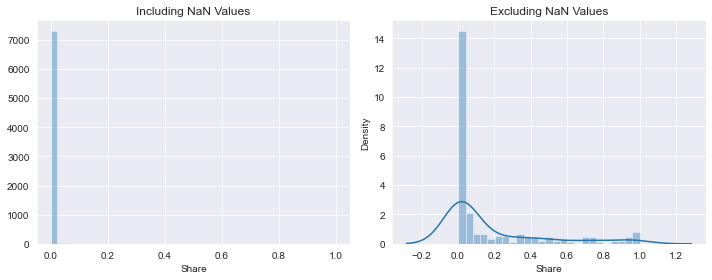

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
sns.distplot(mvp["Share"].fillna(0), ax = ax1, kde = False)
ax1.set_title("Including NaN Values")
sns.distplot(mvp["Share"][~np.isnan(mvp["Share"])], ax = ax2, bins = 25)
ax2.set_title("Excluding NaN Values")
plt.tight_layout()

As suspected, the distribution is heavily skewed to the right. Additionally, the plot on the left reveals how the NaN values are impacting the target variable, making the non-NA valuables statistically insignificant. Therefore, this indicates that we may have to drop the players without a voting share or construct a zero-inflated regression model. I will first create a model without normalizing the target variable and explore multivariate normality of the residuals to ensure the conditions of the regression model are met.

### Bivariate Analysis with Selected Numerical Features

**Standard Statistics**

Text(0.5, 0, 'Points per 36 mins.')

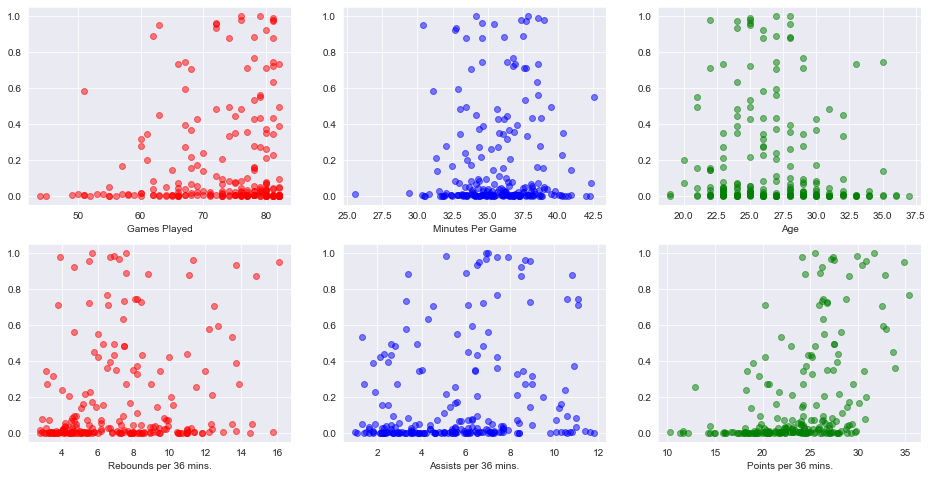

In [101]:
plt.figure(figsize = (16, 8))
plt.subplot(2, 3, 1)
plt.scatter(mvp["G"], mvp["Share"], c = "red", alpha = 0.5)
plt.xlabel("Games Played")

plt.subplot(2, 3, 2)
plt.scatter(mvp["MPG"], mvp["Share"], c = "blue", alpha = 0.5)
plt.xlabel("Minutes Per Game")

plt.subplot(2, 3, 3)
plt.scatter(mvp["Age"], mvp["Share"], c = "green", alpha = 0.5)
plt.xlabel("Age")

plt.subplot(2, 3, 4)
plt.scatter(mvp["TRB"], mvp["Share"], c = "red", alpha = 0.5)
plt.xlabel("Rebounds per 36 mins.")

plt.subplot(2, 3, 5)
plt.scatter(mvp["AST"], mvp["Share"], c = "blue", alpha = 0.5)
plt.xlabel("Assists per 36 mins.")

plt.subplot(2, 3, 6)
plt.scatter(mvp["PTS"], mvp["Share"], c = "green", alpha = 0.5)
plt.xlabel("Points per 36 mins.")

**Advanced Statistics**

Text(0.5, 0, 'Value over Repl. Player')

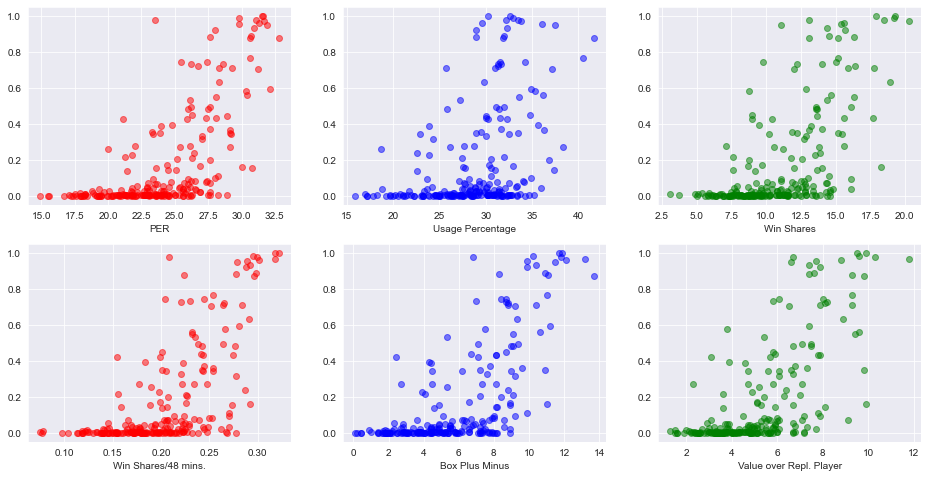

In [100]:
plt.figure(figsize = (16, 8))
plt.subplot(2, 3, 1)
plt.scatter(mvp["PER"], mvp["Share"], c = "red", alpha = 0.5)
plt.xlabel("PER")

plt.subplot(2, 3, 2)
plt.scatter(mvp["USG%"], mvp["Share"], c = "blue", alpha = 0.5)
plt.xlabel("Usage Percentage")

plt.subplot(2, 3, 3)
plt.scatter(mvp["WS"], mvp["Share"], c = "green", alpha = 0.5)
plt.xlabel("Win Shares")

plt.subplot(2, 3, 4)
plt.scatter(mvp["WS/48"], mvp["Share"], c = "red", alpha = 0.5)
plt.xlabel("Win Shares/48 mins.")

plt.subplot(2, 3, 5)
plt.scatter(mvp["BPM"], mvp["Share"], c = "blue", alpha = 0.5)
plt.xlabel("Box Plus Minus")

plt.subplot(2, 3, 6)
plt.scatter(mvp["VORP"], mvp["Share"], c = "green", alpha = 0.5)
plt.xlabel("Value over Repl. Player")

**Main Takeaways**

- The *advanced statistics* seem to have much more of an influence on award voting shares than the *per 36 minute* data.
- It appears that `GP` (Games Played) needs to be at least 60 to even receive a vote for MVP (With a few exceptions), with larger density of points being above 70 games played
- Nearly all players that receive votes for MVP have `MPG` (minutes per game) between 30 and 40 minutes
- The highest voting shares have an `Age` that falls between 23 and 30, with a few high votes between age of 31-33.
- `TRB` and `AST` (rebounds and assists per 36 mins.) seem to have no correlation with MVP votes, however there seems to be a weak, positive correlation between `PTS` (points per 36 mins.) and voting share, with players needing at least 20 points per 36 mins. to even be considered for MVP
- All of the *advanced statistics* seem to have a visible linear relationship with votes
- More will be explored upon the *linear relationship* between the features and target variable in order to fulfill the assumptions of multiple linear regression

### Bivariate Analysis with Selected Categorical Features

(0.1, 1.25)

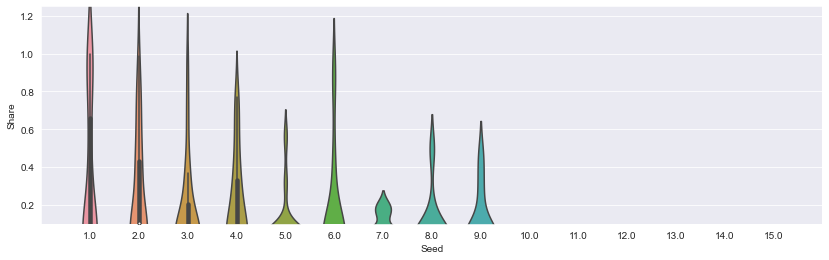

In [581]:
#NOTE: Seeding is ordinal data
plt.figure(figsize = (14, 4))
sns.violinplot(x = "Seed", y = "Share", data = mvp, width = 10)
plt.xlim(-1, 15)
plt.ylim(0.1, 1.25) 
#exlcuding 0-0.1 because there is a unreadable spike in all of the seedings because of the amount of players with low shares

<AxesSubplot:xlabel='Pos', ylabel='Share'>

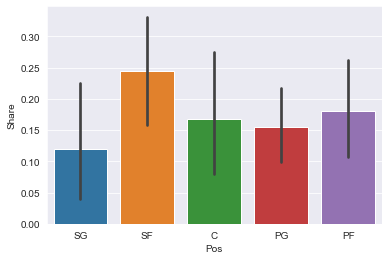

In [133]:
sns.barplot(x = "Pos", y = "Share", data = mvp[mvp["Pos"].isin(['PG', 'SG', 'SF', 'PF', 'C'])])

**Main Takeaways**

- A player's `Seed` must be at least top 9 (Basically making the playoffs) to even receive consideration for MVP. Perhaps, we can feature engineer a new variable which checks whether the player made the playoffs or not.
- Being the first `Seed` in the conference gives higher award shares, while being 2nd-4th seed outputs approximately the same results. Anything below 7th seed heavily impacts the amount of award shares that are received
- A player's `Pos` (position) does play a small role in MVP voting shares as *Small Forwards* have considerably higher average voting shares, whereas *Shooting Guards* have considerably lower voting shares. 
- *Centers*, *Point Guards*, and *Power Forwards* tend to have similar voting shares

## Analysis of Features

In [583]:
mvp["Pos"].unique()

array(['SG', 'SF', 'C', 'PG', 'PF', 'SF-SG', 'PF-SF', 'C-PF', 'SG-PG',
       'PG-SG', 'SG-SF', 'SF-PF', 'PF-C', 'PG-SF', 'SG-PF', 'SG-PG-SF'],
      dtype=object)

### Continuous Numerical Analysis: Checking Normality

I will be checking the normality of the continuous numerical data in case I will be applying a standard scaler on the data, which requires a normal distribution. I anticipate that I will be utilizing StandardScaler since I will be using a Support Vector Regressor model, which requires feature scaling.

Note: Statistics such as field goals attempted and three point attempted are continuous because this data is scaled to per 36 min., not total

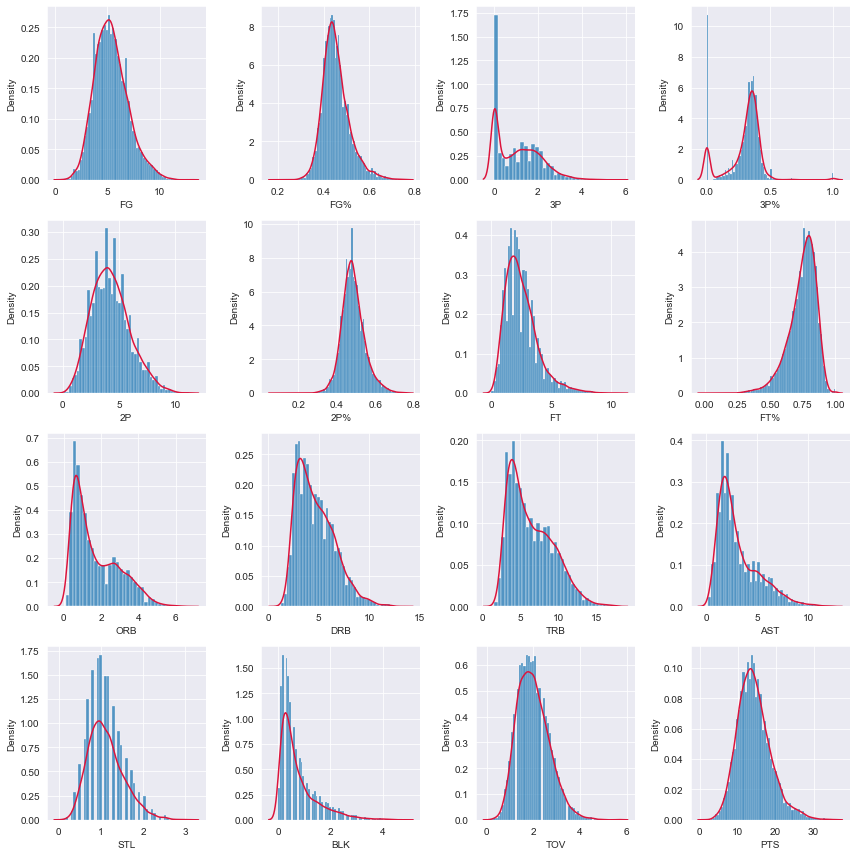

In [166]:
continuous_features = ["FG", "FG%", "3P", "3P%", "2P", "2P%", "FT", "FT%", "ORB", "DRB",
                      "TRB", "AST", "STL", "BLK", "TOV", "PTS"] #for per 36. min data

plt.figure(figsize = (12, 12))
for x, y in enumerate(continuous_features):
    plt.subplot(4, 4, (x + 1))
    sns.histplot(mvp[y], stat = "density")
    sns.kdeplot(mvp[y], color = "crimson")
plt.tight_layout()

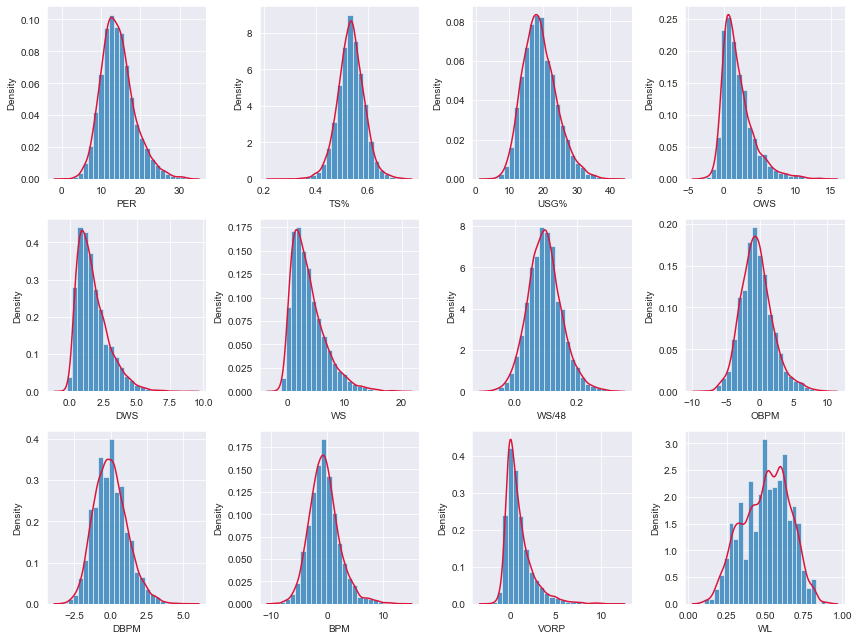

In [170]:
continuous_features = ['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
                       'DBPM', 'BPM', 'VORP', 'WL']

plt.figure(figsize = (12, 9))
for x, y in enumerate(continuous_features):
    plt.subplot(3, 4, (x + 1))
    sns.histplot(mvp[y], stat = "density", bins = 25, kde = False)
    sns.kdeplot(mvp[y], color = "crimson")
plt.tight_layout() 

**Main Takeaways**

- The majority of the continuous features follow a *normal distribution*, and will not require a transformation when constructing the model
- `VORP`, `WS`, `DWS`, `OWS`, `FT`, `TRB`, `AST`, and `BLK` features all have visually skewed. We will furter explore the magnitude of the skewness.
- `WS/48` is normally distributed, so if we discover a linear relationship between `WS/48` and `WS` (Which is expected), we may preserve WS/48 to simplify pre-processing

### Observing Skewness

In [4]:
#checking the skewness for all continous numerical data 
skewed_features = mvp[["Age", "FG", "FG%", "3P", "3P%", "2P", "2P%", "FT", "FT%", "ORB", "DRB",
                      "TRB", "AST", "STL", "BLK", "TOV", "PTS", 'PER', 'TS%', 'USG%', 'OWS', 
                       'DWS', 'WS', 'WS/48', 'OBPM',
                       'DBPM', 'BPM', 'VORP', 'WL']]
skews = pd.DataFrame({"Feature": skewed_features.columns, "Skewness": skew(skewed_features)})
skews[abs(skews["Skewness"]) > 1] #filtering for skewness scores of over 1 (cutoff)

,Feature,Skewness
7,FT,1.239227
12,AST,1.247778
14,BLK,1.757805
20,OWS,1.498044
21,DWS,1.224046
22,WS,1.307991
27,VORP,1.934910


We can see that all of my suspected skewed features from the previous section are skewed with the exception of TRB. Therefore, these features may need to have a log-transformation in order to normalize the data if I use these features.

### Discrete Numerical: 

This section will evaluate the relationship between the discrete numerical features and the target variable using the groupby function to see if certain numerical values result in different mvp voting shares

In [211]:
#checking the descriptive statistics to determine cut ranges
discrete_features = ['Age', 'G', 'GS', 'MP'] 
mvp[discrete_features].describe() 

,Age,G,GS,MP
count,7423.000000,7423.000000,7423.000000,7423.000000
mean,26.704028,67.032736,35.410212,1664.575778
std,4.269466,11.665318,29.300159,709.813111
min,18.000000,42.000000,0.000000,224.000000
25%,23.000000,58.000000,6.000000,1089.500000
50%,26.000000,69.000000,29.000000,1647.000000
75%,30.000000,78.000000,65.000000,2199.000000
max,43.000000,85.000000,83.000000,3485.000000


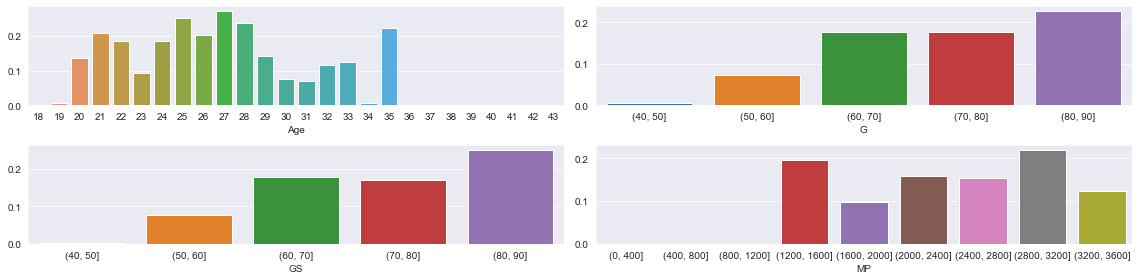

In [218]:
#cutting and grouping the data to create barplots
age = "Age" #does not need to be cut because of small range
games = pd.cut(mvp["G"], np.arange(40, 100, 10))
games_started = pd.cut(mvp["GS"], np.arange(40, 100, 10))
minutes_played = pd.cut(mvp["MP"], np.arange(0, 4000, 400))

plt.figure(figsize = (16, 4))
for x, y in enumerate([age, games, games_started, minutes_played]):
    plt.subplot(2, 2, (x + 1))
    group = mvp.groupby(y)["Share"].mean() #selected mean due to skewed behavior seen earlier
    sns.barplot(x = group.index, y = group.values)
plt.tight_layout()

**Takeaways**
- `MP` must be at least 1200 in order to even be considered for MVP. It seems as though after 1200 minutes played, there isn't a significant impact on a player's MVP voting shares, with the exception of the 2800-3200 cut displaying a particularly higher amount of award share. This is perhaps a result of having a balance between playing enough to be considered valuable, but not too much as to over-exert and exhaust oneself.
- `GS` and `G` follow the exact same distribution, probably because in order to receive MVP shares, that player must already be a starter. Additionally, it seems as though a player needs to play at least 60 games played to have a decent shot at MVP, with playing 80-82 games increases chances significantly
- `Age` seems to have a bimodal distribution with the exception of 35, which may be a result of an outlier (Only one player aged 35 receiving MVP votes - LeBron James). It seems as though being 25-27, or 20-22 increases MVP odds. This may be a result of the player being in their prime, or just entering the league so they receive more fan and media attention. 

### Categorical Data

The relationship between categorical data and the target variable has already been explored in the previous section (Analysis of target variable)

## Analyzing Missing Values

In [225]:
pd.DataFrame(mvp.isna().sum()[mvp.isna().sum() > 0], columns = ["NA Values"])

,NA Values
3P%,582
FT%,2
Share,7197
Seed,800
WL,800


For the MVP dataframe, missing values will not be a large concern as the majority of the data is known

**Analyzing `Seed` and `WL`**

In [230]:
#Checks a sample of players with NaN Seed and WL values
mvp[["Player", "Tm", "Year", "Seed", "WL"]][mvp["Seed"].isna()].iloc[np.arange(0, 800, 50)] 

,Player,Tm,Year,Seed,WL
0,Tariq Abdul-Wahad,TOT,2000,NaN,NaN
688,Tony Delk,TOT,2002,NaN,NaN
1357,Donnell Harvey,TOT,2004,NaN,NaN
1758,Cuttino Mobley,TOT,2005,NaN,NaN
2194,Metta World Peace,TOT,2006,NaN,NaN
2794,Damon Stoudamire,TOT,2008,NaN,NaN
3160,Shelden Williams,TOT,2009,NaN,NaN
3550,Vince Carter,TOT,2011,NaN,NaN
3993,JaVale McGee,TOT,2012,NaN,NaN
4548,Jimmer Fredette,TOT,2014,NaN,NaN


Since `Seed` and `WL` had the same amount of NA values, I suspected that they shared the same rows, which was correct. It appears that the reason there are NaN values is because **the team is unknown** (The player switched teams sometime during the season). As a result, during the concatenationg process of combining the team data with player data, there was no team present in the rankings. 

I will explore the `Tm` feature further, as *TOT* values are representative of missing values. 

In [235]:
(mvp[mvp["Tm"] == "TOT"]["Share"].isna()).sum() #Finds how many players that switched teams didn't receive an MVP vote

795

There are 5 players (800 total *TOT* players) that received an MVP vote despite switching teams

In [238]:
condition = mvp[mvp["Tm"] == "TOT"]["Share"].isna() #takes condition from previous line of code
mvp[mvp["Tm"] == "TOT"][~condition][["Player", "Tm", "Year", "Share"]] #Checks the MVP share of these players

,Player,Tm,Year,Share
1605,Vince Carter,TOT,2005,0.002
2878,Chauncey Billups,TOT,2009,0.027
3328,Stephen Jackson,TOT,2010,0.001
6883,James Harden,TOT,2021,0.001
7013,Derrick Rose,TOT,2021,0.010


Since these 5 players received a substantially small amount of MVP votes, I will drop the players that switched teams from the dataset to address the missing values in `Seed` and `WL`. Additionally, when deploying the final model, no players will have "TOT" as a value for `Tm` since the team is already determined for 2023.

**Analyzing `3P%` and `FT%`**

In [252]:
mvp[mvp["FT%"].isna()][["Player", "Year", "Share"]] #Checking which players have NaN FT% values

,Player,Year,Share
5318,Mike Miller,2016,NaN
5722,Damjan Rudež,2017,NaN


These two rows may be dropped as they are non-essentially.

In [242]:
mvp[mvp["3P%"].isna()].iloc[np.arange(0, 600, 50)] #random sample of players with NaN 3P% values

,Unnamed: 0,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,WS/48,OBPM,DBPM,BPM,VORP,Share,Seed,WL,SS,MPG
14,14,Anthony Avent,PF,30,LAC,49,3,377,2.8,9.2,...,-0.065,-6.9,-0.5,-7.4,-0.5,NaN,14.0,0.183,295,7.693878
500,188,Eric Montross,C,29,TOT,54,21,649,3.1,7.7,...,-0.001,-6.6,-0.1,-6.7,-0.8,NaN,NaN,NaN,299,12.018519
909,288,Clarence Weatherspoon,PF,31,NYK,56,41,1728,3.9,9.4,...,0.097,-0.8,-0.2,-1.1,0.4,NaN,13.0,0.366,243,30.857143
1317,78,Michael Doleac,C,26,TOT,72,0,1029,4.9,11.3,...,0.079,-2.3,0.1,-2.2,0.0,NaN,NaN,NaN,205,14.291667
1775,224,Shaquille O'Neal*,C,32,MIA,73,73,2492,9.5,15.8,...,0.211,4.1,1.2,5.3,4.6,NaN,1.0,0.720,6,34.136986
2207,11,Hilton Armstrong,C,22,NOK,56,5,634,3.9,7.1,...,0.091,-2.9,0.3,-2.6,-0.1,NaN,10.0,0.476,279,11.321429
2665,141,D.J. Mbenga,C,27,TOT,42,0,326,4.3,9.3,...,0.066,-5.7,0.4,-5.3,-0.3,NaN,NaN,NaN,283,7.761905
3378,212,Nazr Mohammed,C,32,CHA,58,29,984,6.9,12.5,...,0.174,0.6,-0.1,0.5,0.6,NaN,7.0,0.537,78,16.965517
3931,112,Udonis Haslem,PF,31,MIA,64,10,1589,3.4,8.1,...,0.106,-2.2,-0.2,-2.4,-0.2,NaN,2.0,0.697,252,24.828125
4469,30,Aron Baynes,C,27,SAS,53,4,491,5.2,12.0,...,0.055,-4.7,-1.0,-5.7,-0.5,NaN,1.0,0.756,230,9.264151


There seems to be no explicit cause, so I will further explore other variables to see if there's a pattern

In [243]:
mvp[mvp["3P%"].isna()][["Player", "Year", "3P", "3PA"]]

,Player,Year,3P,3PA
14,Anthony Avent,2000,0.0,0.0
37,Mark Bryant,2000,0.0,0.0
68,Antonio Davis,2000,0.0,0.0
70,Dale Davis,2000,0.0,0.0
75,Andrew DeClercq,2000,0.0,0.0
...,...,...,...,...
7322,Onyeka Okongwu,2022,0.0,0.0
7350,Nick Richards,2022,0.0,0.0
7354,Mitchell Robinson,2022,0.0,0.0
7407,Hassan Whiteside,2022,0.0,0.0


As seen above, the reason 3P% is NaN is because these players never attempted a three pointer during the season. To address this, I will *impute* 0% into these values as not attempting a three is equivalent to having a 0% three point rate.

**Analyzing `Share` (Target variable)**

Utilizing domain knowledge, we know that `Share` has NaN values as a result of that player not receiving an MVP vote. Therefore, all of these values can be imputed with 0. This is further analyzed in the *Univariate Analyis of Target Variable* section. As a result of the overwhelming amount of 0 values, we may remove these players when constructing the model or take a small sample

## Analyzing the Impact of Outliers

As discovered earlier in exploring the distribution of the features, the following distributions are not normal, thus suggesting that there may be outliers in the data. I will further explore these outliers through boxplots.

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

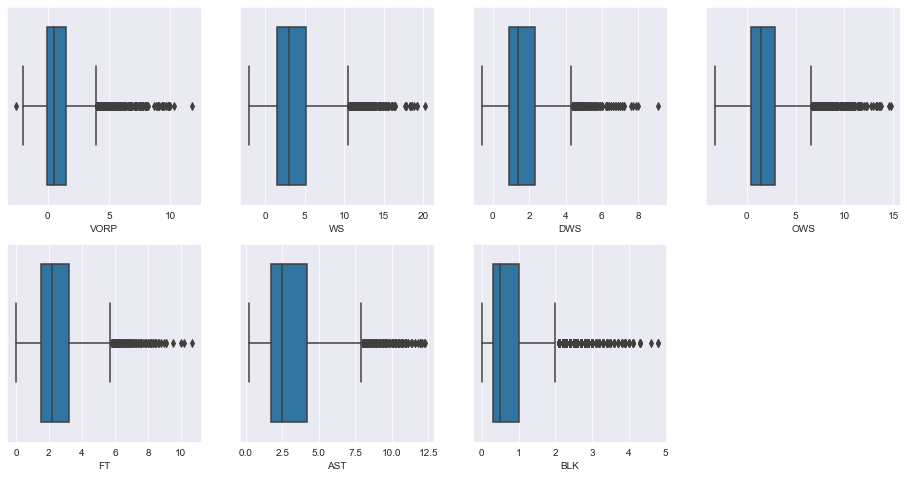

In [491]:
features = ["VORP", "WS", "DWS", "OWS", "FT", "AST", "BLK"]
plt.figure(figsize = (16, 8))
for i, j in enumerate(features):
    plt.subplot(2, 4, (i + 1))
    sns.boxplot(x = j, data = mvp)
    
plt.tight_layout

As suspected, these variables all have a large amount of outliers. Let's perform a log-transformation to analyze the impact and whether or not there would still be outliers.

/Users/justingong/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/justingong/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


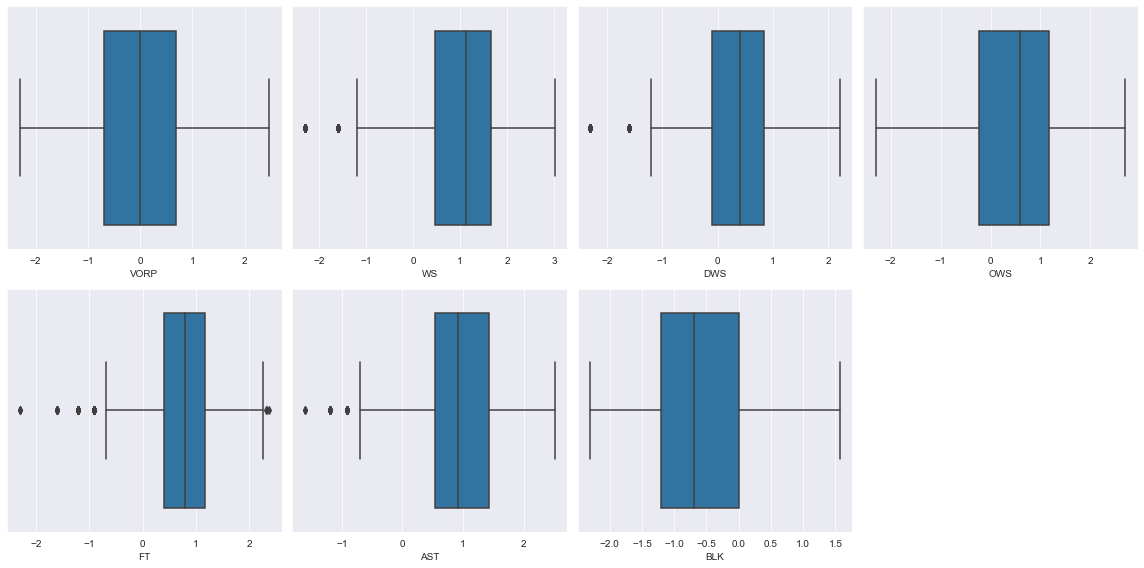

In [524]:
#creating a function to perform the log transformation
def log_transform(data):
    transformed = np.log(data)
    transformed.replace([np.inf, -np.inf], np.nan, inplace = True)
    return transformed

transformed_data = mvp[features].apply(log_transform)
plt.figure(figsize = (16, 8))

for i, j in enumerate(features):
    plt.subplot(2, 4, (i + 1))
    sns.boxplot(x = j, data = transformed_data)
plt.tight_layout()

Clearly, applying the log transformation significantly reduced the number of outliers in the skewed data and normalized the features more. In model construction, we may apply the log transformation to these features if they end up going into the final model.

## Multicollinearity - Bivariate Collinearity

First, I'll explore the specific correlation between each feature and the target variable.

In [345]:
mvp.drop(["Unnamed: 0", "Player", "Pos", "Tm", "Share"], axis = 1).columns

Index(['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'Year', 'PER', 'TS%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Seed', 'WL', 'SS',
       'MPG'],
      dtype='object')

In [355]:
#creating series with each correlation coefficient between numerical features and target variable
num_features = mvp.drop(["Unnamed: 0", "Player", "Pos", "Tm", "Share"], axis = 1)
correlations = num_features.apply(lambda x: x.corr(mvp["Share"]))
abs(correlations).sort_values(ascending = False)

VORP     0.683044
BPM      0.677851
PER      0.662652
WS/48    0.645798
WS       0.612311
OBPM     0.610200
OWS      0.538404
PTS      0.455625
DBPM     0.443528
USG%     0.413570
FG       0.394921
FTA      0.394669
FT       0.392842
TS%      0.388533
TOV      0.356089
DWS      0.344364
WL       0.341560
2P%      0.322911
Seed     0.304831
FGA      0.291165
SS       0.244133
DRB      0.234665
2P       0.221372
3PA      0.213484
AST      0.212073
3P       0.207805
FG%      0.201111
TRB      0.182672
Year     0.175584
STL      0.163521
GS       0.114602
G        0.107395
3P%      0.101723
MP       0.097223
2PA      0.093784
PF       0.091648
Age      0.074943
BLK      0.060581
MPG      0.033756
FT%      0.022564
ORB      0.009102
dtype: float64

First, I'll observe the correlation coefficient for features with an anticipated linear relationship, and decide which one's are necessary to keep. This will be done through correlograms.

<AxesSubplot:>

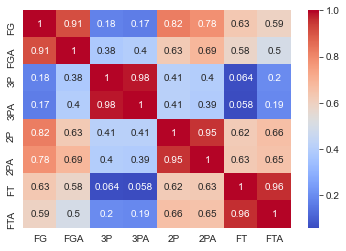

In [266]:
#Analyzing correlation between field goal statistics
field_goals = abs(mvp[["FG", "FGA", "3P", "3PA", "2P", "2PA", "FT", "FTA"]].corr())
sns.heatmap(field_goals, cmap = "coolwarm", annot = True)

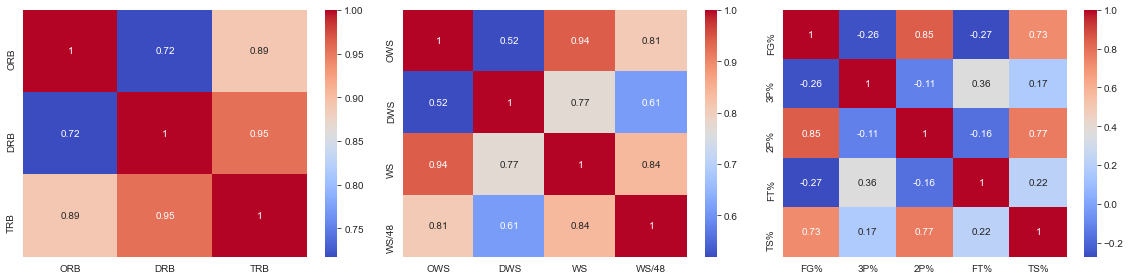

In [274]:
#Analyzing correlation between other related statistic types
rebounds = ["ORB", "DRB", "TRB"]
win_shares = ["OWS", "DWS", "WS", "WS/48"]
shooting = ["FG%", "3P%", "2P%", "FT%", "TS%"]

plt.figure(figsize = (16, 4))
for x, y in enumerate([rebounds, win_shares, shooting]):
    plt.subplot(1, 3, (x + 1))
    sns.heatmap(mvp[y].corr(), cmap = "coolwarm", annot = True)
plt.tight_layout()

In [341]:
#Checking specific correlation between variables
print("Points and Scoring Standing: {:>21.3f}".format(mvp[["PTS", "SS"]].corr().iloc[1, 0]))
print("Seed and Win/Loss: {:>31.3f}".format(mvp[["Seed", "WL"]].corr().iloc[1, 0]))
print("Box Plus Minus and Offensive Box Plus Minus: {:>2.3f}".format(mvp[["BPM", "DBPM"]].corr().iloc[1,0]))
print("Games and Games Started: {:>25.3f}".format(mvp[["G", "GS"]].corr().iloc[1,0]))
print("Minutes and Minutes per Game: {:>20.3f}".format(mvp[["MP", "MPG"]].corr().iloc[1,0]))

Points and Scoring Standing:                -0.927
Seed and Win/Loss:                          -0.947
Box Plus Minus and Offensive Box Plus Minus: 0.467
Games and Games Started:                     0.449
Minutes and Minutes per Game:                0.930


The cut-off correlation coefficient is 0.7 (absolute value). With this information:
- `FG` and `FGA`, `2P` and `2PA`, `3P` and `3PA`, `FT` and `FTA` are highly correlated. There was also a correlation between `FG` and `2P`. 
    - **`FG`, `3P`, `FT`** will be kept because the amount made is more important than the amount attempted. Additionally, I've selected `FG` over `2P` because total field goals provides more information about a player's offensive game than their 2 pointers.
- `TRB` are highly correlated with `ORB` and `DRB` as expected. **`DRB`** will be kept because it is better correlated with the target variable.
- `WS/48` is highly correlated with `WS`, `OWS`, and `DWS` as expected. **`WS/48`** will be kept because it is better correlated with the target variable and is normally distributed as discovered before *(Analysis of Continuous Numerical Features)*
- **`3P%`** and **`FT%`** are not correlated with other shooting variables. `TS%` is highly correlated with `2P%` and `FG%`. **`TS%`** will be kept because it is much better correlated with the target.
- **`PTS`** will be kept over `SS`
- **`WL`** will be kept over `Seed`
- **`MP`** will be kept over `MPG`

To complete our bivariate analysis, I'll create a finalized correlation matrix with reduced features.

In [372]:
correlations = mvp[["Age", "GS", "MP", "FG", "DRB", "AST", "STL", 
                    "BLK", "TOV", "PF", "PTS", "PER", "TS%", "USG%", "WS/48", 
                    "BPM", "OBPM", "VORP"]].corr()

#will highlight values that are above or equal to 0.7
def highlight(value):
    criteria = value >= 0.7
    return ["background-color: red" if x else "" for x in criteria]

correlations.style.apply(highlight)

,Age,GS,MP,FG,DRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,USG%,WS/48,BPM,OBPM,VORP
Age,1.000000,0.020964,0.007407,-0.133470,-0.002548,0.080397,-0.026741,-0.070765,-0.110646,-0.067930,-0.118716,-0.029398,0.023008,-0.131392,0.106301,0.102621,0.047238,0.069114
GS,0.020964,1.000000,0.825350,0.373152,0.131996,0.198783,0.043113,0.038851,0.195664,-0.354036,0.373557,0.476370,0.220368,0.341632,0.352073,0.479051,0.500035,0.562364
MP,0.007407,0.825350,1.000000,0.442158,0.018087,0.267471,0.093109,-0.081329,0.214672,-0.486131,0.473235,0.538540,0.251193,0.444569,0.391604,0.567170,0.622398,0.648591
FG,-0.133470,0.373152,0.442158,1.000000,0.175025,0.196443,-0.010092,0.000345,0.439734,-0.277530,0.958083,0.781711,0.359430,0.898493,0.429187,0.545758,0.700221,0.554462
DRB,-0.002548,0.131996,0.018087,0.175025,1.000000,-0.349020,-0.201865,0.596952,0.035253,0.331540,0.087988,0.381396,0.241941,0.002574,0.397344,0.217276,0.088930,0.189674
AST,0.080397,0.198783,0.267471,0.196443,-0.349020,1.000000,0.408987,-0.415681,0.575531,-0.417283,0.255790,0.264475,-0.056478,0.350708,0.073124,0.355091,0.388970,0.370415
STL,-0.026741,0.043113,0.093109,-0.010092,-0.201865,0.408987,1.000000,-0.212425,0.218706,-0.137827,0.024396,0.128636,-0.109151,0.081308,0.071585,0.293881,0.124689,0.254570
BLK,-0.070765,0.038851,-0.081329,0.000345,0.596952,-0.415681,-0.212425,1.000000,-0.054680,0.445502,-0.088642,0.230463,0.163522,-0.146976,0.277548,0.106897,-0.083375,0.070558
TOV,-0.110646,0.195664,0.214672,0.439734,0.035253,0.575531,0.218706,-0.054680,1.000000,-0.017319,0.460161,0.370764,-0.049259,0.627465,-0.002243,0.189027,0.244066,0.267486
PF,-0.067930,-0.354036,-0.486131,-0.277530,0.331540,-0.417283,-0.137827,0.445502,-0.017319,1.000000,-0.342965,-0.247161,-0.090358,-0.316452,-0.098233,-0.414902,-0.536708,-0.389463


- `GS` and `MP` are highly correlated. `GS` will be kept because it is better correlated with the target variable.
- `FG` is highly correlated with multiple features. This will be removed as other features can deduce the same information.
- `BPM` and `OBPM` will be removed because they are highly correlated with multiple features. 
- `WS/48` and `VORP` will be kept despite being correlated because it is moderate

## Multicollinearity - Variance Inflated Factor

After reducing some of the features, we can do a final test through *Variance Inflated Factor* to remove multicollinearity before proceeding to constructing the ML models. NOTE: Further analysis of features will be done through feature selection.

I will perform the Variance Inflated Factor method utlizing different features to minimize the linearity between the dependent variables. First, I'll explore the variance inflated factor for *all* features:

In [405]:
#creates new dataframe with numerical features
all = mvp[['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 
           'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
           'PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM','DBPM','BPM', 'VORP', 'Seed', 'WL', 'SS', 'MPG']]
all = all.dropna()

vf_table = pd.DataFrame()
vf_table["Feature"] = all.columns
vf_table["VIF"] = [variance_inflation_factor(all.values, x) for x in range(len(all.columns))]
vf_table

,Feature,VIF
0,Age,46.245115
1,G,417.680268
2,GS,10.513874
3,MP,562.991804
4,FG,31431.003641
5,FGA,62133.158987
6,FG%,2304.865508
7,3P,1829.431949
8,3PA,6824.006902
9,3P%,9.506913


As we can see, the VIF scores are incredibly high, which will definitely cause problems when constructing an ML model. Now, let's run the same method using reduced features from what we learned in the previous section.

In [408]:
reduced = mvp[['Age', 'G', 'GS', '3P', '3P%','FT', 'FT%', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 
               'PF', 'PTS','PER', 'TS%', 'USG%', 'WS/48', 'VORP', 'WL']]
reduced = reduced.dropna()

vf_table2 = pd.DataFrame()
vf_table2["Feature"] = reduced.columns
vf_table2["VIF"] = [variance_inflation_factor(reduced.values, x) for x in range(len(reduced.columns))]
vf_table2

,Feature,VIF
0,Age,44.351163
1,G,46.640323
2,GS,4.840743
3,3P,10.071586
4,3P%,8.808744
5,FT,20.862397
6,FT%,107.753343
7,DRB,17.671145
8,AST,15.119710
9,STL,12.351809


<AxesSubplot:xlabel='Feature', ylabel='VIF'>

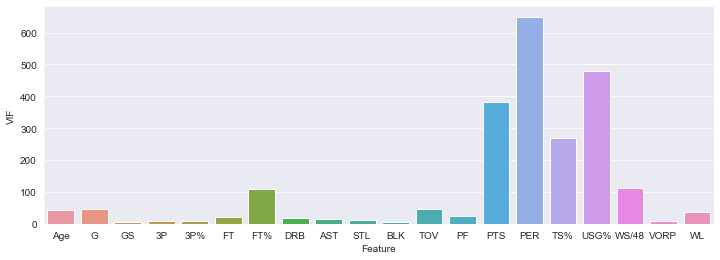

In [416]:
plt.figure(figsize = (12, 4))
sns.barplot(x = "Feature", y = "VIF", data = vf_table2)

The data is still displaying extreme multicollinearity. This will be addressed and reduced in the next part of the project in feature selection.

# 2. Most Improved Player

**NOTE:** For this section, we'll primarly be looking at the new features (Change from previous year data). We won't be dealing with the other features as we've heavily explored them in the previous section for Most Valuable Player.

## Univariate Analysis of Target Variable

In [424]:
mip["Share"].describe()

count    580.000000
mean       0.064767
std        0.146150
min        0.002000
25%        0.005000
50%        0.010000
75%        0.042250
max        0.988000
Name: Share, dtype: float64

Before graphing the distribution plot of the MIP voting shares, I can tell that there will be a right skewed distribution because the mean is greater than the median. Additionally, we can see the max value is much larger than the 75% quartile

Text(0.5, 1.0, 'Distribution of Most Value Player Voting Shares')

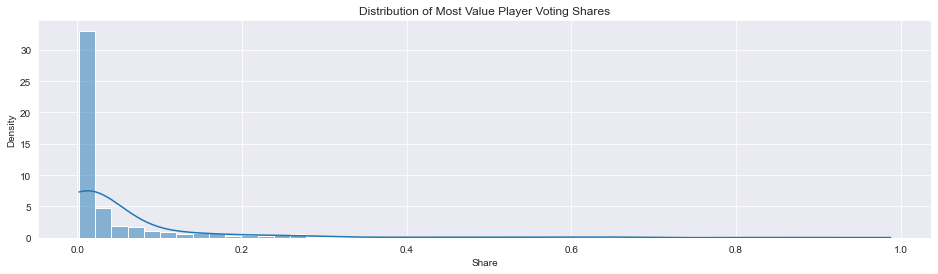

In [445]:
plt.figure(figsize = (16, 4))
sns.histplot(mip["Share"][~np.isnan(mip["Share"])], bins = 50, stat = "density", kde = True)
plt.title("Distribution of Most Value Player Voting Shares")

As suspected, the distribution is heavily skewed to the right. I will first create a model without normalizing the target variable and explore multivariate normality of the residuals to ensure the conditions of the regression model are met.

## Bivariate Analysis with Selected Features

### Numerical Features

**% Change Features** (Relative improvement from previous season)

Text(0.5, 0, 'Points per 36 mins.')

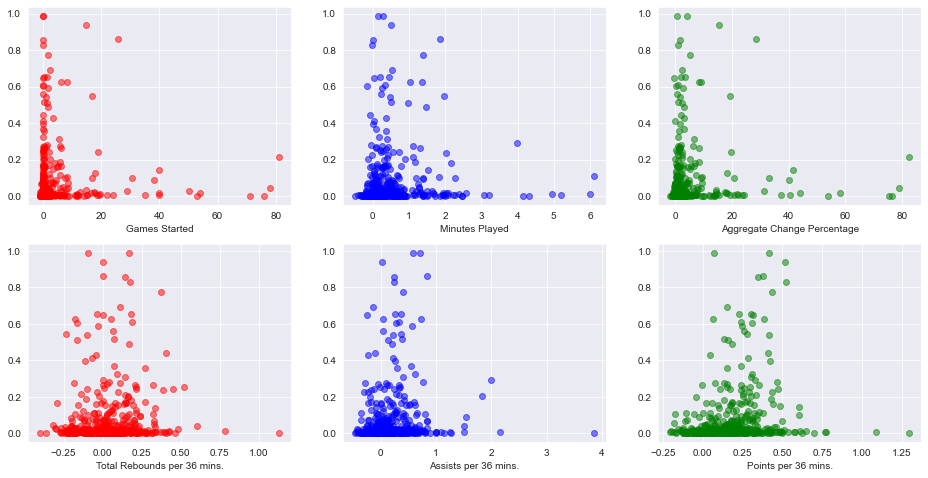

In [456]:
#'GS - %', 'MP - %', 'TS% - %', 'TRB - %', 'AST - %', 'STL - %', 'BLK - %', 'PTS - %'
plt.figure(figsize = (16, 8))
plt.subplot(2, 3, 1)
plt.scatter(mip["GS - %"], mip["Share"], c = "red", alpha = 0.5)
plt.xlabel("Games Started")

plt.subplot(2, 3, 2)
plt.scatter(mip["MP - %"], mip["Share"], c = "blue", alpha = 0.5)
plt.xlabel("Minutes Played")

plt.subplot(2, 3, 3)
plt.scatter(mip["AGG"], mip["Share"], c = "green", alpha = 0.5)
plt.xlabel("Aggregate Change Percentage")

plt.subplot(2, 3, 4)
plt.scatter(mip["TRB - %"], mip["Share"], c = "red", alpha = 0.5)
plt.xlabel("Total Rebounds per 36 mins.")

plt.subplot(2, 3, 5)
plt.scatter(mip["AST - %"], mip["Share"], c = "blue", alpha = 0.5)
plt.xlabel("Assists per 36 mins.")

plt.subplot(2, 3, 6)
plt.scatter(mip["PTS - %"], mip["Share"], c = "green", alpha = 0.5)
plt.xlabel("Points per 36 mins.")

**Quantitative Change** (Actual improvement from previous season)

Text(0.5, 0, 'Points per 36 mins.')

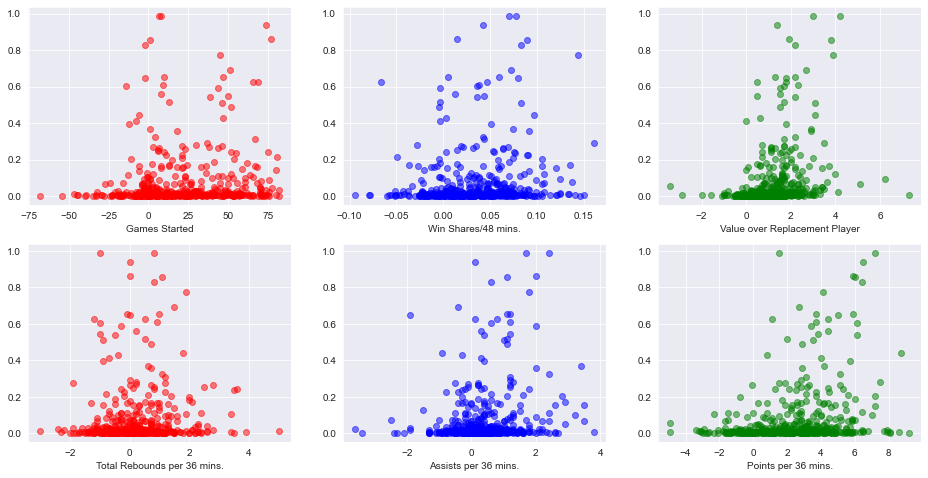

In [462]:
plt.figure(figsize = (16, 8))
plt.subplot(2, 3, 1)
plt.scatter(mip["GS - Q"], mip["Share"], c = "red", alpha = 0.5)
plt.xlabel("Games Started")

plt.subplot(2, 3, 2)
plt.scatter(mip["WS/48 - Q"], mip["Share"], c = "blue", alpha = 0.5)
plt.xlabel("Win Shares/48 mins.")

plt.subplot(2, 3, 3)
plt.scatter(mip["VORP - Q"], mip["Share"], c = "green", alpha = 0.5)
plt.xlabel("Value over Replacement Player")

plt.subplot(2, 3, 4)
plt.scatter(mip["TRB - Q"], mip["Share"], c = "red", alpha = 0.5)
plt.xlabel("Total Rebounds per 36 mins.")

plt.subplot(2, 3, 5)
plt.scatter(mip["AST - Q"], mip["Share"], c = "blue", alpha = 0.5)
plt.xlabel("Assists per 36 mins.")

plt.subplot(2, 3, 6)
plt.scatter(mip["PTS - Q"], mip["Share"], c = "green", alpha = 0.5)
plt.xlabel("Points per 36 mins.")

**Main Takeaways**

- There seems to be non direct linear correlation between the change variables and MIP, which may result in an inaccurate model as it'll depend on the linearity between the features and target variable.
- All of the `% change variables` seem to be at least 0%, meaning that most statistics of the player has *improved* from the previous season. This suggests that to be even considered for the MIP award, almost all of a player's statistics must have a positive improvement otherwise the player will not even be considered for the award. 
- It seems like both quantitative and percentage change follows approximately the same relationship with award shares --> Since I expect high multicollinearity, I can select one category through further analysis

### Categorical Features

<AxesSubplot:xlabel='Age', ylabel='Share'>

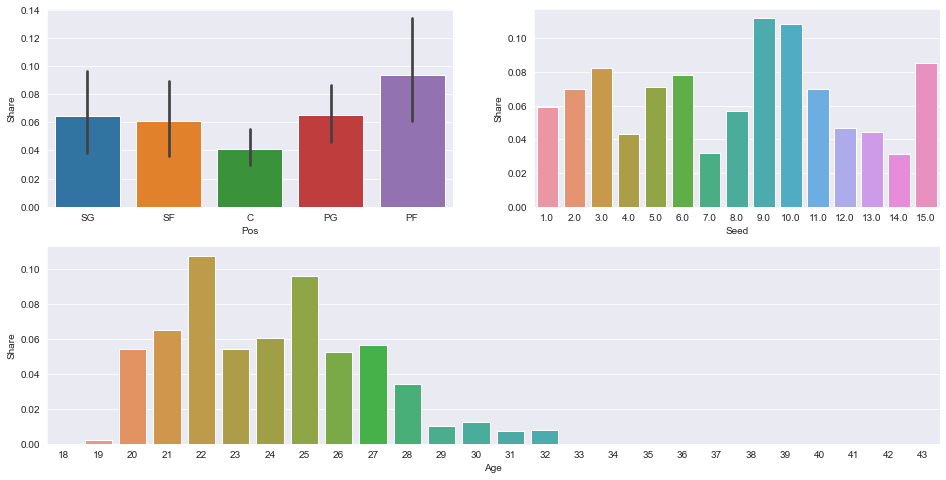

In [576]:
plt.figure(figsize = (16, 8))
plt.subplot(2, 2, 1)
sns.barplot(x = "Pos", y = "Share", data = mip[mip["Pos"].isin(['PG', 'SG', 'SF', 'PF', 'C'])])

plt.subplot(2, 2, 2)
sns.barplot(x = mvp["Seed"], y = mip["Share"], ci = False)

plt.subplot(2, 1, 2)
sns.barplot(x = mvp["Age"], y = mip["Share"], ci = False)

**Takeaways**
- *Power Fowards* have a considerably higher award voting share than *Centers* for most improved player. Other than this, the other positions are all around the mean award share. I suspect this is a result of power forwards and centers having similar roles on a team (Both positioned in the frontcourt), but power forwards have a greater capacity for improvement as their role is less-defined, but centers are more limited.
- Unlike the MVP award share, the `Seed` of a player almost doesn't matter at all when deciding the *MIP*. In fact, unlike MVPs, a larger majority of the most improved player award shares went to players that did NOT make the playoffs. Perhaps, this is a result of non-title contending teams devoting more time for backup players to develop and improve.
- It appears that once a player's `Age` is above 29, then they don't receive many votes for MIP. The best age to be to win this age is 22 and 25. This may be because 22 year olds begin to understand the game better and improve, while 25 year olds are just about to enter their prime.

### Evaluating Correlation Between Numerical Features and Target Variable

In [577]:
#Quantitative Variables
mip[['GS - Q', 'MP - Q', 'TS% - Q', 'TRB - Q', 'AST - Q', 'STL - Q', 'BLK - Q', 
     'PTS - Q', 'PER - Q', 'USG% - Q', 'WS - Q', 'WS/48 - Q', 'BPM - Q', 'VORP - Q', "Share"]].corr()["Share"]

GS - Q       0.128520
MP - Q       0.134781
TS% - Q      0.079767
TRB - Q      0.082944
AST - Q      0.183443
STL - Q     -0.005292
BLK - Q      0.053638
PTS - Q      0.275317
PER - Q      0.272952
USG% - Q     0.238949
WS - Q       0.227259
WS/48 - Q    0.139543
BPM - Q      0.224055
VORP - Q     0.301451
Share        1.000000
Name: Share, dtype: float64

In [569]:
#Relative Variables
mip[[ 'GS - %', 'MP - %', 'TS% - %', 'TRB - %', 'AST - %', 'STL - %', 'BLK - %', 
     'PTS - %', 'AGG', "Share"]].corr()["Share"]

GS - %     0.031840
MP - %     0.043014
TS% - %    0.067610
TRB - %    0.080178
AST - %    0.103144
STL - %   -0.010942
BLK - %    0.085980
PTS - %    0.216123
AGG        0.052375
Share      1.000000
Name: Share, dtype: float64

In [580]:
#Regular Variables
mip[['G', 'GS', 'MP', 'FG','FGA', '3P', '3PA', '2P', '2PA', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'Year', 'PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'Share']].corr()["Share"]

G        0.030775
GS       0.175204
MP       0.171783
FG       0.148236
FGA      0.136966
3P       0.049478
3PA      0.051728
2P       0.095424
2PA      0.092164
TRB      0.051463
AST      0.110024
STL      0.029669
BLK     -0.013519
TOV      0.146804
PF      -0.057812
PTS      0.163738
Year     0.068097
PER      0.169066
TS%      0.064735
USG%     0.147940
OWS      0.155515
DWS      0.090645
WS       0.160993
WS/48    0.115203
OBPM     0.184275
DBPM     0.020377
BPM      0.166448
VORP     0.177070
Share    1.000000
Name: Share, dtype: float64

## Analysis of Features

### Continuous Numerical Features: Checking Normality

First, I'll start with % change and then analyze quantitative change. This will support in deciding which features to keep because I'd like to have normal distributions when constructing a model.

**Relative Features**

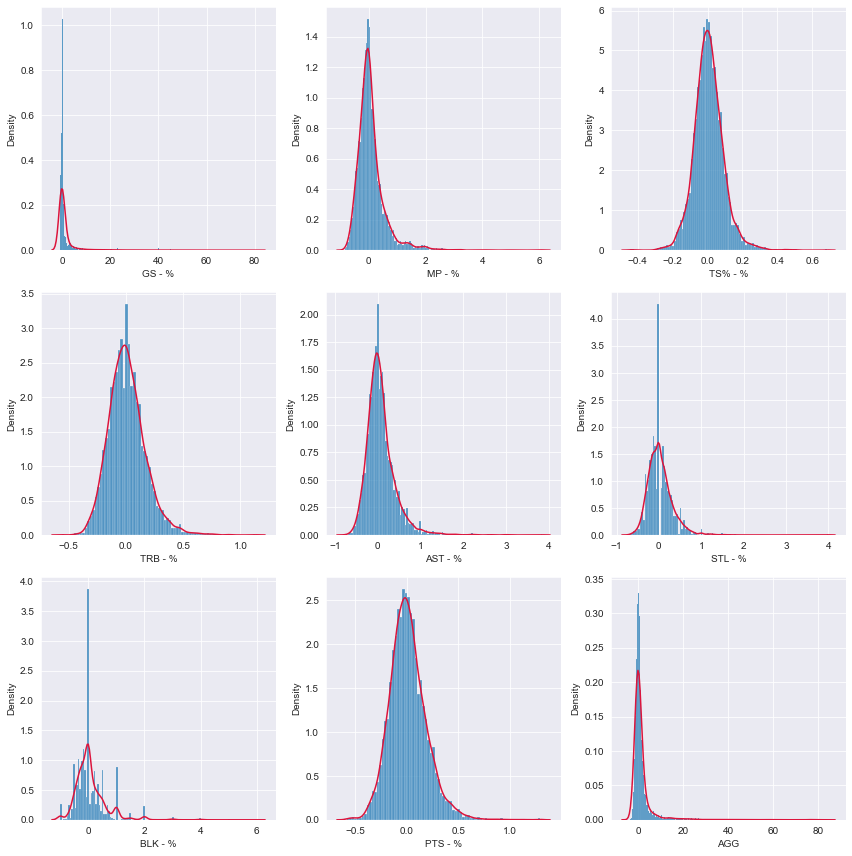

In [477]:
relative_features = ['GS - %', 'MP - %', 'TS% - %', 'TRB - %', 'AST - %', 'STL - %', 
                    'BLK - %', 'PTS - %', 'AGG'] 

plt.figure(figsize = (12, 12))
for x, y in enumerate(relative_features):
    #removes inf values as they cannot be plotted
    plot = mip[y]
    plot.replace([np.inf, -np.inf], np.nan, inplace = True)
    plot.dropna()
    
    plt.subplot(3, 3, (x + 1))
    sns.histplot(plot, stat = "density")
    sns.kdeplot(plot, color = "crimson")
plt.tight_layout()

**Quantitative Features**

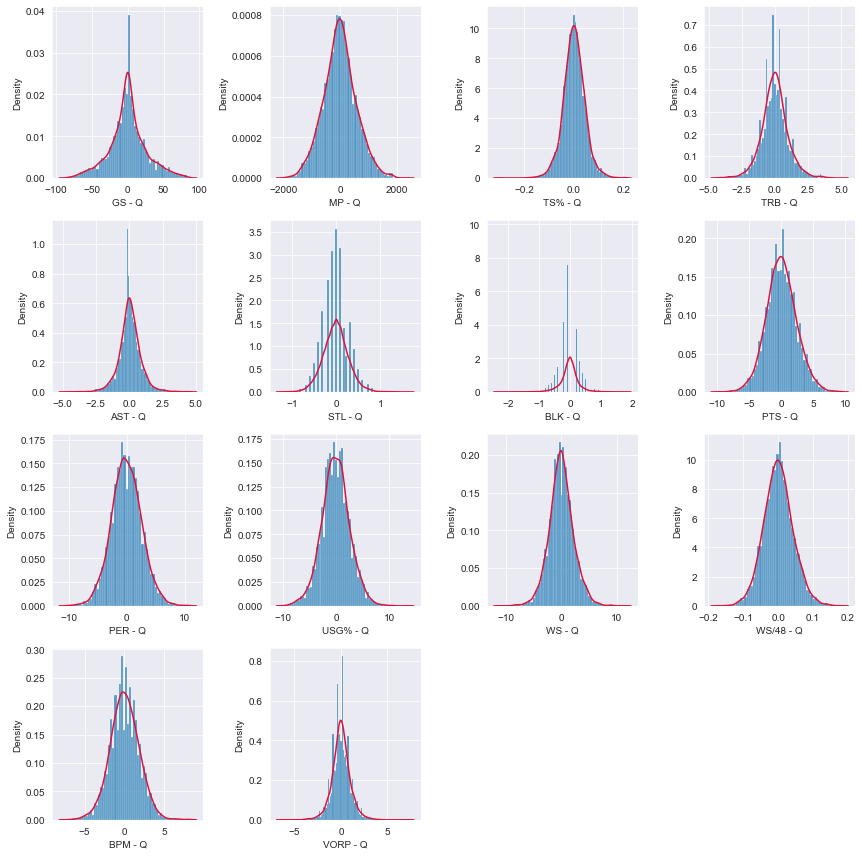

In [479]:
quantitative_features = ['GS - Q', 'MP - Q', 'TS% - Q', 'TRB - Q', 'AST - Q', 'STL - Q', 'BLK - Q', 
                         'PTS - Q', 'PER - Q', 'USG% - Q', 'WS - Q', 'WS/48 - Q', 'BPM - Q', 'VORP - Q']
    
plt.figure(figsize = (12, 12))
for x, y in enumerate(quantitative_features):
    #removes inf values as they cannot be plotted
    plot = mip[y]
    plot.replace([np.inf, -np.inf], np.nan, inplace = True)
    plot.dropna()
    
    plt.subplot(4, 4, (x + 1))
    sns.histplot(plot, stat = "density")
    sns.kdeplot(plot, color = "crimson")
plt.tight_layout()

- All of the `Quantitative Change` features display normality
- The majority of the *relative change* features display normality, with the exception of `GS` and `MP`
- I will evaluate the skewness to determine whether or not these are problematic

### Observing Skewness

In [487]:
#checking the skewness for all new continous numerical data 
skewed_features = mip[['GS - %', 'MP - %', 'TS% - %', 'TRB - %', 'AST - %', 'STL - %', 'BLK - %', 
                       'PTS - %', 'AGG', 'GS - Q', 'MP - Q', 'TS% - Q', 'TRB - Q', 'AST - Q', 'STL - Q', 
                       'BLK - Q', 'PTS - Q', 'PER - Q', 'USG% - Q', 'WS - Q', 'WS/48 - Q', 'BPM - Q',
                       'VORP - Q']]

skewed_features.dropna(inplace = True)

skews = pd.DataFrame({"Feature": skewed_features.columns, "Skewness": skew(skewed_features)})
skews[abs(skews["Skewness"]) > 1] #filtering for skewness scores of over 1 (cutoff)

<ipython-input-487-199cc51faff2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skewed_features.dropna(inplace = True)


,Feature,Skewness
0,GS - %,7.180825
1,MP - %,2.351476
4,AST - %,2.031778
5,STL - %,2.103008
6,BLK - %,2.192117
8,AGG,6.733454


It appears that the relative change are more heavily skewed, making me more inclined to keep the quantitative changes to evaluate MIP award shares. I will further explore this in multicollinearity, where I explore the linear relationship between the features and the target variable.

## Missing Values and Outliers

In [527]:
mip_na = mip.isna().sum()
mip_na[mip_na > 0]

Share        6843
GS - %       2337
MP - %       2005
TS% - %      2005
TRB - %      2005
AST - %      2005
STL - %      2005
BLK - %      2114
PTS - %      2005
AGG          2432
GS - Q       2005
MP - Q       2005
TS% - Q      2005
TRB - Q      2005
AST - Q      2005
STL - Q      2005
BLK - Q      2005
PTS - Q      2005
PER - Q      2005
USG% - Q     2005
WS - Q       2005
WS/48 - Q    2005
BPM - Q      2005
VORP - Q     2005
dtype: int64

In [536]:
mip[mip["VORP - Q"].isna()][["GS - Q", "MP - Q", "TS% - Q", "TRB - Q", "AST - Q", "STL - Q", "BLK - Q", "PTS - Q",
                            "PER - Q", "USG% - Q", "WS - Q", "WS/48 - Q", "BPM - Q", "MP - %", "TS% - %", "AST - %",
                            "STL - %", "TRB - %", "PTS - %"]].isna().sum()

GS - Q       2005
MP - Q       2005
TS% - Q      2005
TRB - Q      2005
AST - Q      2005
STL - Q      2005
BLK - Q      2005
PTS - Q      2005
PER - Q      2005
USG% - Q     2005
WS - Q       2005
WS/48 - Q    2005
BPM - Q      2005
MP - %       2005
TS% - %      2005
AST - %      2005
STL - %      2005
TRB - %      2005
PTS - %      2005
dtype: int64

As it appears, all of the values that has 2005 NaN values share the same NA values. This is being while I was constructing this dataset and created these features, it relied on statistics from the previous season. For example, Stephen Curry's features in 2017 relied on the improvement from 2016. Therefore, every column from 2000 is NaN because 1999 was not webscraped, and anytime a player did not play the previous season (At least half the games), then they were not in the dataset.

However, there are still additional NaN values, which I will further investigate

In [537]:
mip_na = mip.isna().sum()
mip_na[mip_na > 2005]

Share      6843
GS - %     2337
BLK - %    2114
AGG        2432
dtype: int64

I anticipate to remove `AGG` as it had absolutely no correlation with the target variable. I will further explore `GS - %` and `BLK - %`. 

**GS - %** and **BLK - %**

In [563]:
#creates subset of the dataframe without the other NaN values
df_reduced_na = mip.dropna(subset = ["VORP - Q"])

df_reduced_na[df_reduced_na["GS - %"].isna()][["Player", "Year", "GS - %"]]

,Player,Year,GS - %
320,Chucky Atkins,2001,NaN
321,Stacey Augmon,2001,NaN
325,Dana Barros,2001,NaN
331,Travis Best,2001,NaN
338,Cal Bowdler,2001,NaN
...,...,...,...
7258,John Konchar,2022,NaN
7301,Malik Monk,2022,NaN
7314,Jaylen Nowell,2022,NaN
7366,Anfernee Simons,2022,NaN


In [565]:
df_reduced_na[df_reduced_na["BLK - %"].isna()][["Player", "Pos", "Year", "BLK - %"]]

,Player,Pos,Year,BLK - %
375,Vinny Del Negro,PG,2001,NaN
382,Bryce Drew,PG,2001,NaN
429,Troy Hudson,PG,2001,NaN
524,Milt Palacio,PG,2001,NaN
531,Elliot Perry,PG,2001,NaN
...,...,...,...,...
6858,Bryn Forbes,SG,2021,NaN
7090,D.J. Augustin,PG,2022,NaN
7131,Jalen Brunson,SG,2022,NaN
7146,Amir Coffey,SG,2022,NaN


There doesn't appear to be a clear reason as to why there are additional NA values in these columns, however, I suspect that it's because in the previous year, the GS and BLK values for these players were 0, therefore the relative change was Inf, which was imputed as NaN in this dataframe. This is seen through the BLK - % NaN values being players in the backcourt, who would normally not get blocks. Thus, I could imputate these values as **0%**.

**`Share`**

We already know that the NaN share values are present because these players received *no* votes for the award that year. Therefore, we can imputate these NaN values as 0. 

## Multicollinearity

This section has been shortened because we have already explored the relationship between the features in the Most Valuable Player section.

<AxesSubplot:>

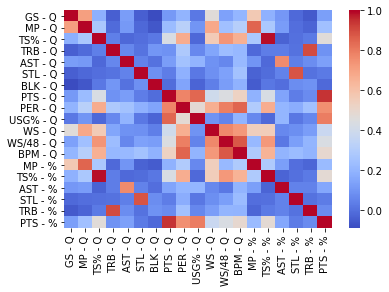

In [30]:
features = ["GS - Q", "MP - Q", "TS% - Q", "TRB - Q", "AST - Q", "STL - Q", "BLK - Q", "PTS - Q", 
            "PER - Q", "USG% - Q", "WS - Q", "WS/48 - Q", "BPM - Q", "MP - %", "TS% - %", "AST - %", 
            "STL - %", "TRB - %", "PTS - %"]

sns.heatmap(mip[features].corr(), cmap = "coolwarm")

It seems like for the most, the data is primarily blue, meaning there is no correlation between the variables. It seems like there is higher correlation between the % and Q variables that share the same base feature. This would make sense because they are both measuring the same thing. Additionally, it seems like the change in *advanced statistics* are particularly higher. This would make as a result of what we found in the MVP section.

Let's observe the VIF scores for each the different types of features respectively.

**Relative Change**

In [35]:
relative = mip[['GS - %', 'MP - %', 'TS% - %', 'TRB - %', 'AST - %', 'STL - %', 'BLK - %', 'PTS - %']]
relative = relative.replace(np.inf, np.nan)
relative = relative.dropna()

vf_table = pd.DataFrame()
vf_table["Feature"] = ['GS - %', 'MP - %', 'TS% - %', 'TRB - %', 'AST - %', 'STL - %', 'BLK - %', 'PTS - %']
vf_table["VIF"] = [variance_inflation_factor(relative.values, x) for x in range(len(relative.columns))]
vf_table

,Feature,VIF
0,GS - %,1.224769
1,MP - %,1.337099
2,TS% - %,1.364490
3,TRB - %,1.017778
4,AST - %,1.071549
5,STL - %,1.012681
6,BLK - %,1.017555
7,PTS - %,1.356016


**Quantitative Change**

In [36]:
quant = mip[['GS - Q', 'MP - Q', 'TS% - Q', 'TRB - Q', 'AST - Q', 'STL - Q', 'BLK - Q', 
                'PTS - Q', 'PER - Q', 'USG% - Q', 'WS - Q', 'WS/48 - Q', 'BPM - Q', 'VORP - Q']]
quant = quant.dropna()

vf_table = pd.DataFrame()
vf_table["Feature"] = quant.columns
vf_table["VIF"] = [variance_inflation_factor(quant.values, x) for x in range(len(quant.columns))]
vf_table

,Feature,VIF
0,GS - Q,2.101175
1,MP - Q,6.303504
2,TS% - Q,4.483346
3,TRB - Q,1.348167
4,AST - Q,1.450830
5,STL - Q,1.262647
6,BLK - Q,1.174139
7,PTS - Q,17.471653
8,PER - Q,13.903817
9,USG% - Q,11.683994


**Takeaways**

In general, the change variables are not correlated as shown by both the heatmap and the variance inflated factor scores. The only variables displaying multicollinearity are the advanced statistics, which we will reduce using lasso regressor reduction.

# 3. Defensive Player of the Year

## Analysis of Target Variable

(array([249.,  24.,  13.,   7.,   5.,   8.,   2.,   0.,   5.,   6.]),
 array([0.002 , 0.0993, 0.1966, 0.2939, 0.3912, 0.4885, 0.5858, 0.6831,
        0.7804, 0.8777, 0.975 ]),
 <BarContainer object of 10 artists>)

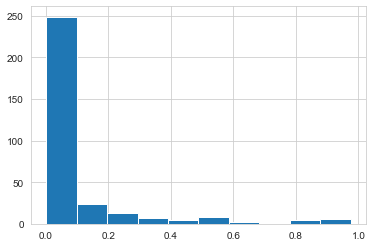

In [63]:
sns.set_style("whitegrid")
plt.hist(dpoy["Share"])

<AxesSubplot:>

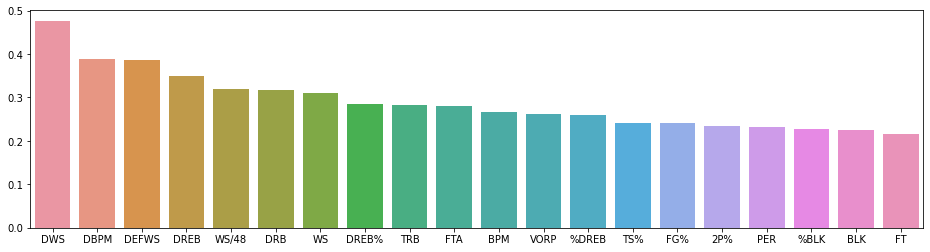

In [59]:
#creating series with each correlation coefficient between numerical features and target variable
num_features = dpoy.drop(["Unnamed: 0", "Player", "Pos", "Tm", "Share"], axis = 1)
correlations = num_features.apply(lambda x: x.corr(dpoy["Share"]))
scores = abs(correlations).sort_values(ascending = False)[:20]

plt.figure(figsize = (16, 4))
sns.barplot(x = scores.index, y = scores.values)

<AxesSubplot:xlabel='Pos', ylabel='Share'>

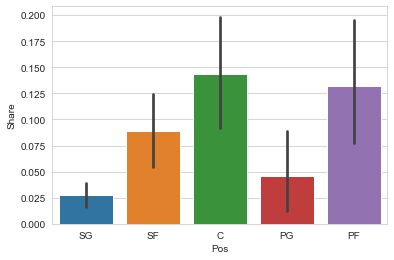

In [68]:
sns.barplot(x = "Pos", y = "Share", data = dpoy[dpoy["Pos"].isin(['PG', 'SG', 'SF', 'PF', 'C'])])

**Main Takeaways**

- It seems like the majority of the features are not strongly linearly correlated with the DPOY voting share. This makes me think that the multiple linear regression model may not be the best model to use.
- The distribution of the DPOY share follows the same distribution as the other awards.
- There is obvious spike in centers and power forwards winning defensive player of the year. This could be a result of their role in teams being focused more in defensive (Protecting the rim). Whereas shooting guards and point guards are more responsible for facilitating the offense. Therefore, the model may inaccurately predict the 2022 DPOY (Marcus Smart) because he is a point guard. I'll keep this in mind when evaluating the model.

## Analyzing Missing Values

In [13]:
dpoy_na = dpoy.isna().sum()
dpoy_na[dpoy_na > 0]

3P%                   582
FT%                     2
Share                7104
DEF RTG               781
DREB                  781
DREB%                 781
%DREB                 781
STL%                  781
%BLK                  781
OPP PTSOFF TOV        781
OPP PTS2ND CHANCE     781
OPP PTSFB             781
OPP PTSPAINT          781
DEFWS                 781
dtype: int64

**`3P%`** and **`FT%`**

In [9]:
dpoy[dpoy["3P%"].isna()][["Player", "Year", "3P", "3PA", "3P%"]]

,Player,Year,3P,3PA,3P%
14,Anthony Avent,2000,0.0,0.0,NaN
37,Mark Bryant,2000,0.0,0.0,NaN
68,Antonio Davis,2000,0.0,0.0,NaN
70,Dale Davis,2000,0.0,0.0,NaN
75,Andrew DeClercq,2000,0.0,0.0,NaN
...,...,...,...,...,...
7322,Onyeka Okongwu,2022,0.0,0.0,NaN
7350,Nick Richards,2022,0.0,0.0,NaN
7354,Mitchell Robinson,2022,0.0,0.0,NaN
7407,Hassan Whiteside,2022,0.0,0.0,NaN


As suspected, these players never attepted a 3 pointer or free throw. Therefore, I can assign these NA values with 0%

**Variables with 781 missing values**

In [20]:
dpoy[dpoy["DEFWS"].isna()][["Player", "Year", "DEFWS"]].iloc[range(0, 781, 50)]

,Player,Year,DEFWS
2,Ray Allen*,2000,NaN
496,Reggie Miller*,2001,NaN
850,Željko Rebrača,2002,NaN
1272,Chris Bosh*,2004,NaN
1700,Allen Iverson*,2005,NaN
2045,Nenad Krstić,2006,NaN
2401,Yao Ming*,2007,NaN
2737,Andrés Nocioni,2008,NaN
3137,Roko Ukić,2009,NaN
3609,Francisco García,2011,NaN


As we can see, these are all players with either an asterisk or diacritics in the names. Since we webscraped data from NBA.com AND basketball-reference.com, the way the player names were written were different. Thus, when merging datasets, the players were not found as a result of these special characters. Let's investigate whether or not these 781 players are significant.

In [24]:
dpoy[dpoy["DEFWS"].isna()][["Player", "Year", "Share"]].sort_values("Share", ascending = False).head(10)

,Player,Year,Share
3459,Anderson Varejão,2010,0.030
7413,Robert Williams,2022,0.016
3138,Anderson Varejão,2009,0.005
1772,Andrés Nocioni,2005,0.002
2082,Andrés Nocioni,2006,0.002
3134,Hedo Türkoğlu,2009,0.002
6024,Jusuf Nurkić,2018,0.002
2,Ray Allen*,2000,NaN
13,Isaac Austin,2000,NaN
36,Kobe Bryant*,2000,NaN


We may drop all of these players since only 7 players ever received DPOY votes, and the highest voting share was only .03, which is insigificant.

**`Share`**

As we discovered from previous sections, `Share` has many NaNs because these plays never received a DPOY vote. Therefore, we can imputate with 0.

# 4. Rookie of the Year

## Analysis of Target Variable

<AxesSubplot:xlabel='Share', ylabel='Density'>

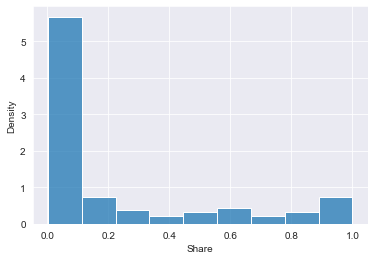

In [62]:
sns.set_style("darkgrid")
sns.histplot(roy["Share"], stat = "density")

Unlike the other awards, the rookie of the year voting share distribution isn't as right skewed. This could mean that rookies tend to player similarly well, causing many players to receive ROY votes. 

<AxesSubplot:>

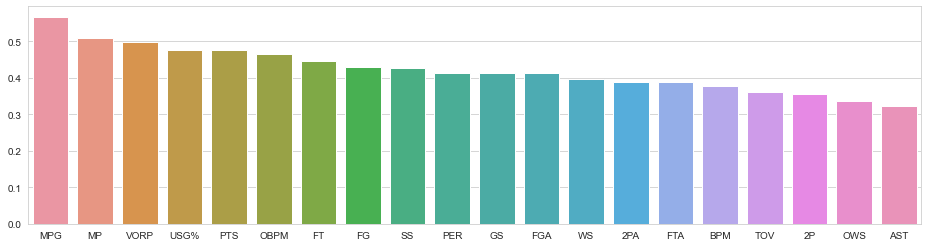

In [64]:
#creating series with each correlation coefficient between numerical features and target variable
num_features = roy.drop(["Unnamed: 0", "Player", "Pos", "Tm", "Share"], axis = 1)
correlations = num_features.apply(lambda x: x.corr(roy["Share"]))
scores = abs(correlations).sort_values(ascending = False)[:20]

plt.figure(figsize = (16, 4))
sns.barplot(x = scores.index, y = scores.values)

**Main Takeaways**

- Interestly, the most correlated feature for ROY is the MPG. This means that rookies that have more playing time tend to also receive more votes.
- Similarly to MVP, the advanced statistics are the most correlated with the ROY share. However, since a lot of these are correlated with one another, we may need to utilize a model resistant to correlated features, or reduce through feature selection.
- Unlike DPOY, a lot of features for ROY are correlated decently with the share (Linearly). This may mean a multiple linear regression model may fit better than it would have for DPOY.

# 5. Sixth Man of the Year

## Analysis of Target Variable

<AxesSubplot:xlabel='Share', ylabel='Density'>

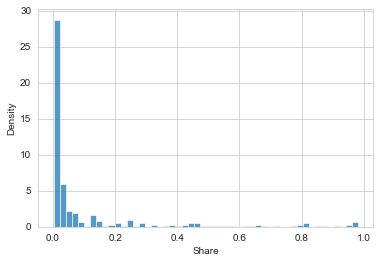

In [65]:
sns.histplot(smoy["Share"], stat = "density")

<AxesSubplot:>

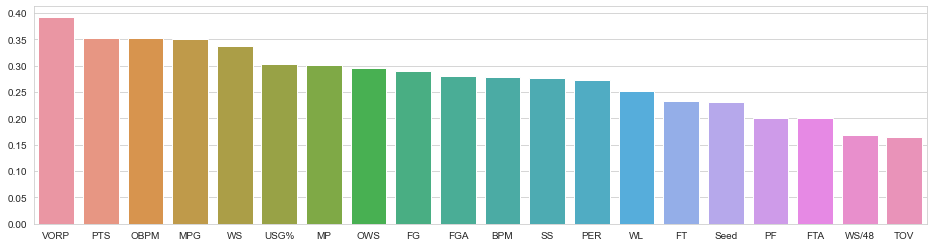

In [66]:
#creating series with each correlation coefficient between numerical features and target variable
num_features = smoy.drop(["Unnamed: 0", "Player", "Pos", "Tm", "Share"], axis = 1)
correlations = num_features.apply(lambda x: x.corr(smoy["Share"]))
scores = abs(correlations).sort_values(ascending = False)[:20]

plt.figure(figsize = (16, 4))
sns.barplot(x = scores.index, y = scores.values)

<AxesSubplot:xlabel='Pos', ylabel='Share'>

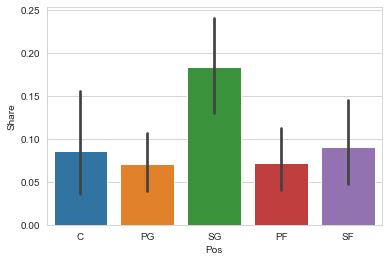

In [67]:
sns.barplot(x = "Pos", y = "Share", data = smoy[smoy["Pos"].isin(['PG', 'SG', 'SF', 'PF', 'C'])])

**Main Takeaways**
- Unfortunately, many features are not strongly correlated with the target variable. The highest being VORP with less than 0.4 correlation. This may mean that a multiple linear regression model may not be the best for SMOY.
- There is an obvious spike in the winner for SMOY for shooting guards, even considering the confidence interval. This may be a result of common winners, such as Lou Williams, for the reward tend to be shooting guards. However, this can also suggest that shooting guards have a bigger role off the bench. However, the position isn't predictive for SMOY shares, but is rather correlated in history.